<h3 style = "font-size:40px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049; text-align: center; border-radius: 5px 5px; padding: 5px">AWS SageMaker Experiments with Weights and Biases on IMDB Movie Reviews Dataset </h3>

In this notebook we will use Amazon SageMaker experiments to organize, track, compare and evaluate our machine learning experiments on IMDB movie reviews dataset then deploy the endpoint for best training job or trial component. We will add custom metrics definitions to capture and visualize training metrics and history using SageMaker TrainingJobAnalytics and Weights and Biases as well.

AWS SageMaker Experiments:

We might have used notepad or excel sheets to keep track of training jobs, experiments (like trying different algorithms, hyperparameters etc) and performance metrics (accuracy, f1 score etc) in our data science projects.

AWS SageMaker experiments will help us in organizing, tracking, finding the best performing model, save valuable time of data scientists and let them focus on actual ML work.

Let's understand the key terms.
1. Experiment: It's a collection of trials.
2. Trial: It's a collection of trial components. A trial contains the metadata for inputs (e.g. algorithm, parameters, data sets) and outputs (e.g. models, checkpoints, metrics)
3. Trial component: It's basically preprocessing, training and model evaluation steps etc which are involved in a single experiment.

<a id = '0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #007580; color : #fed049; border-radius: 5px 5px; text-align:center; font-weight: bold" >Table of Contents</h2> 

1. [Problem Statement](#1.0)
2. [Setup](#2.0)
3. [Download the dataset and data preprocessing](#3.0)
4. [Upload datasets to Amazon S3](#4.0)
5. [Set up the Experiment](#5.0)
6. [Track Experiment](#6.0)
7. [Accessing Training Metrics using Experiments UI from SageMaker Studio](#7.0)
8. [Accessing Training Metrics using SageMaker TrainingJobAnalytics API](#8.0)
9. [Accessing Training Metrics using Weights and Biases](#9.0)
10. [Compare the model training runs for an experiment](#10.0)
11. [Deploy endpoint for the best training-job or trial component](#11.0)
12. [Model inference](#12.0)
13. [Clean up](#13.0)
14. [Conclusion and references](#14.0)

Please note that the objective of this notebook is not to build a robust model, but rather how to fine-tune a HuggingFace BERT model on SageMaker with different hyper-parameters, set up an experiment, track the experiment and deploy the best performing model. Let’s go through each step in detail.

<a id = '1.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 1. Problem Statement </h2>

Our job is to classify whether IMDB movie reviews are positive or negative sentiment and it's a binary classification problem.

<a id = '2.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 2. Setup </h2>

To start, we install some required libraries, import some Python libraries and initialize a SageMaker session, S3 bucket and prefix, and IAM role.

NOTE: You can run this demo in Sagemaker Studio with "PyTorch 1.12 Python 3.8 CPU Optimized" kernel.

In [ ]:
!pip install -qq "transformers==4.17.0" "datasets[s3]==1.18.3" "sagemaker-experiments==0.1.24" "sagemaker==2.80.0" "seaborn" --upgrade

In [ ]:
import sagemaker
import sagemaker.huggingface
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker
from sagemaker.session import Session

from sagemaker.huggingface import HuggingFace
from sagemaker.pytorch import PyTorch

In [ ]:
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

<a id = '3.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 3. Download the dataset and data preprocessing </h2>

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

# tokenizer used in preprocessing
tokenizer_name = 'distilbert-base-uncased'

# dataset used
dataset_name = 'imdb'

# s3 key prefix for the data
s3_prefix = 'samples/datasets/imdb'

#### Tokenization

In [ ]:
# load dataset
dataset = load_dataset(dataset_name)

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# load dataset
train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'], ignore_verifications=True)
train_dataset = train_dataset.shuffle().select(range(5000)) # smaller the size for test dataset to 5k 
test_dataset = test_dataset.shuffle().select(range(2500)) # smaller the size for test dataset to 2.5k 

In [ ]:
# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# set format for pytorch
train_dataset =  train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

<a id = '4.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 4. Upload datasets to Amazon S3 </h2>

In [ ]:
import botocore
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()  

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path,fs=s3)

# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path,fs=s3)

Now lets track the parameters from the data pre-processing step.

In [ ]:
import boto3
import time

boto3_sess = boto3.Session()
sm = boto3_sess.client("sagemaker")

with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters(
        {
            "normalization_mean": 0.1307,
            "normalization_std": 0.3081,
        }
    )
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="imdb-train-dataset", media_type="s3/uri", value=training_input_path)
    tracker.log_input(name="imdb-test-dataset", media_type="s3/uri", value=test_input_path)

<a id = '5.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 5. Set up the Experiment </h2>

Create an experiment to track all the model training iterations. Experiments are a great way to organize our data science work. We can create experiments to organize all our model development work for : 
[1] a business use case we are addressing (e.g. create experiment named “sentiment analysis of imdb movie reviews”), or 
[2] a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”), or 
[3] a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

### Create an Experiment

In [ ]:
imdb_experiment = Experiment.create(
    experiment_name=f"imdb-movie-reviews-classification-{int(time.time())}",
    description="Classification of imdb movie reviews",
    sagemaker_boto_client=sm,
)
print(imdb_experiment)

<a id = '6.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 6. Track Experiment </h2>

### Now create a Trial for each training run to track the it's inputs, parameters, and metrics.
While training the BERT model on SageMaker, we will experiment with several values for the model learning rate. We will create a Trial to track each training job run. We will also create a TrialComponent from the tracker we created before, and add to the Trial. This will enrich the Trial with the parameters we captured from the data pre-processing stage.

In [ ]:
preprocessing_trial_component = tracker.trial_component
learning_rate_trial_name_map = {}

### Launching a Training Job with custom metrics

In [ ]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

To start, we use the `PyTorch` estimator class to train our model. When creating our estimator, we make sure to specify a few things:

* `entry_point`: the name of our PyTorch script. It contains our training script, which loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model. It also contains code to load and run the model during inference.
* `source_dir`: the location of our training scripts and requirements.txt file. "requirements.txt" lists packages you want to use with your script.
* `framework_version`: the PyTorch version we want to use

After creating the estimator, we then call fit(), which launches a training job. We use the Amazon S3 URIs where we uploaded the training data earlier.

<img src = "./img/sm-estimator.png" >

#### Learning Rate's effect on model performance

We are going to experiment with three learning rates and see their effects on model performance.

The code is fairly straight-forward. We just need to create multiple estimators with different learning rates, and run the estimator in a non-blocking manner via `wait=False` which means each training job will run independently and parallelly.

In [ ]:
for i, learning_rate in enumerate([3e-5, 4e-5, 5e-5]):
    # create trial
    trial_name = f"bert-training-job-{learning_rate}-learning-rate-{int(time.time())}"
    bert_trial = Trial.create(
        trial_name=trial_name,
        experiment_name=imdb_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    learning_rate_trial_name_map[learning_rate] = trial_name
    
    # associate the proprocessing trial component with the current trial
    bert_trial.add_trial_component(preprocessing_trial_component)
    
    pytorch_estimator = PyTorch(entry_point="train_deploy.py",
                                source_dir="./code", role=role,
                                framework_version="1.9", py_version="py38",
                                instance_count=1,                         
                                instance_type="ml.p3.2xlarge",
                                hyperparameters={
                                    "epochs": 5,
                                    "train_batch_size": 32,
                                    "checkpoints": "/opt/ml/checkpoints/",
                                    "model_name":"distilbert-base-uncased",
                                    "learning_rate": learning_rate
                                },
                                metric_definitions=metric_definitions,
                               )

    bert_training_job_name = "bert-training-job-{}".format(int(time.time()))
    
    # Now associate the estimator with the Experiment and Trial
    pytorch_estimator.fit(
        inputs={'train': training_input_path, 'test': test_input_path}, job_name=bert_training_job_name,
        experiment_config={
            "TrialName": bert_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        }, wait=False,)

<a id = '7.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 7. Accessing Training Metrics using Experiments UI from SageMaker Studio</h2>

The training jobs don't emit metrics immediately. For example, it first needs to provision a training instance, download the training image, download the data, train and evaluate a model. Hence it's recommended to wait until the completion of all training jobs.

We can access the created experiment - "imdb-movie-reviews-classification-1671348177" from step 5 in the Studio interface.

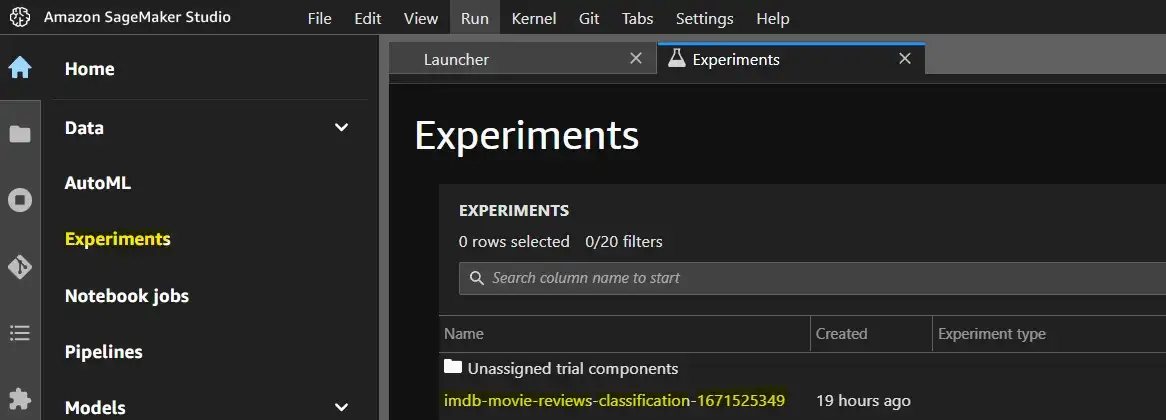

We can look at the trial details by double clicking the above experiment.

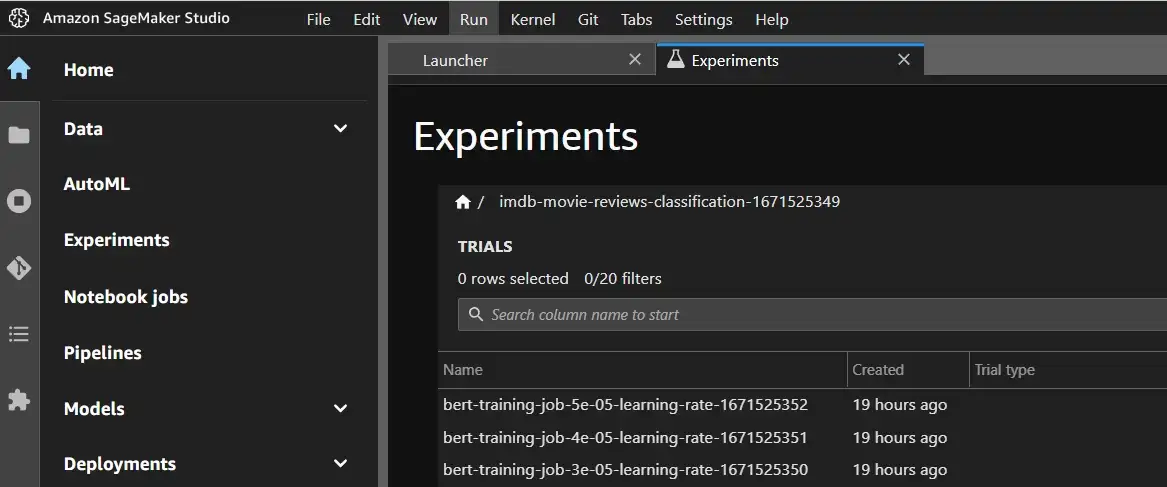

As mentioned earlier, we’ve experimented with three different learning rates and respective training jobs or trial components can be accessed by right clicking each trial and “open in trial component list”

Note: We have an option to “Deploy model” as well, I tried deploying it from here but endpoint creation has failed at the time of writing this post hence we will try to deploy the best training job or training component using SageMaker Python SDK and verify the model inference results.

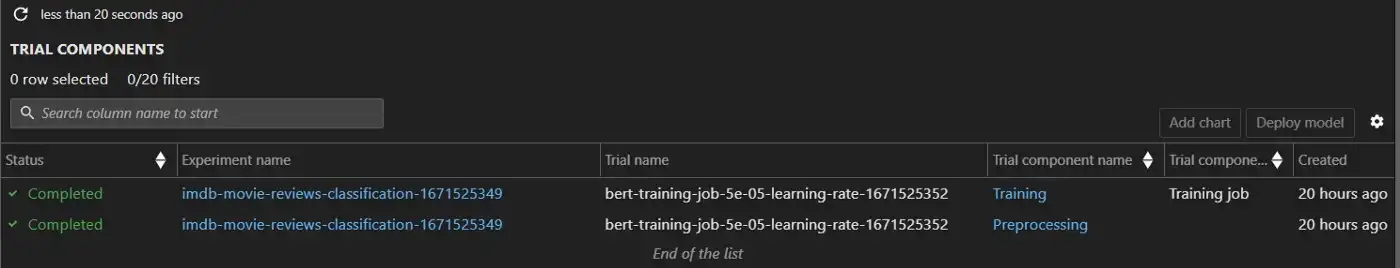

Let’s open the “bert-training-job-5e-05-learning-rate-1671525352” trial or training job and visualize the following training metrics.

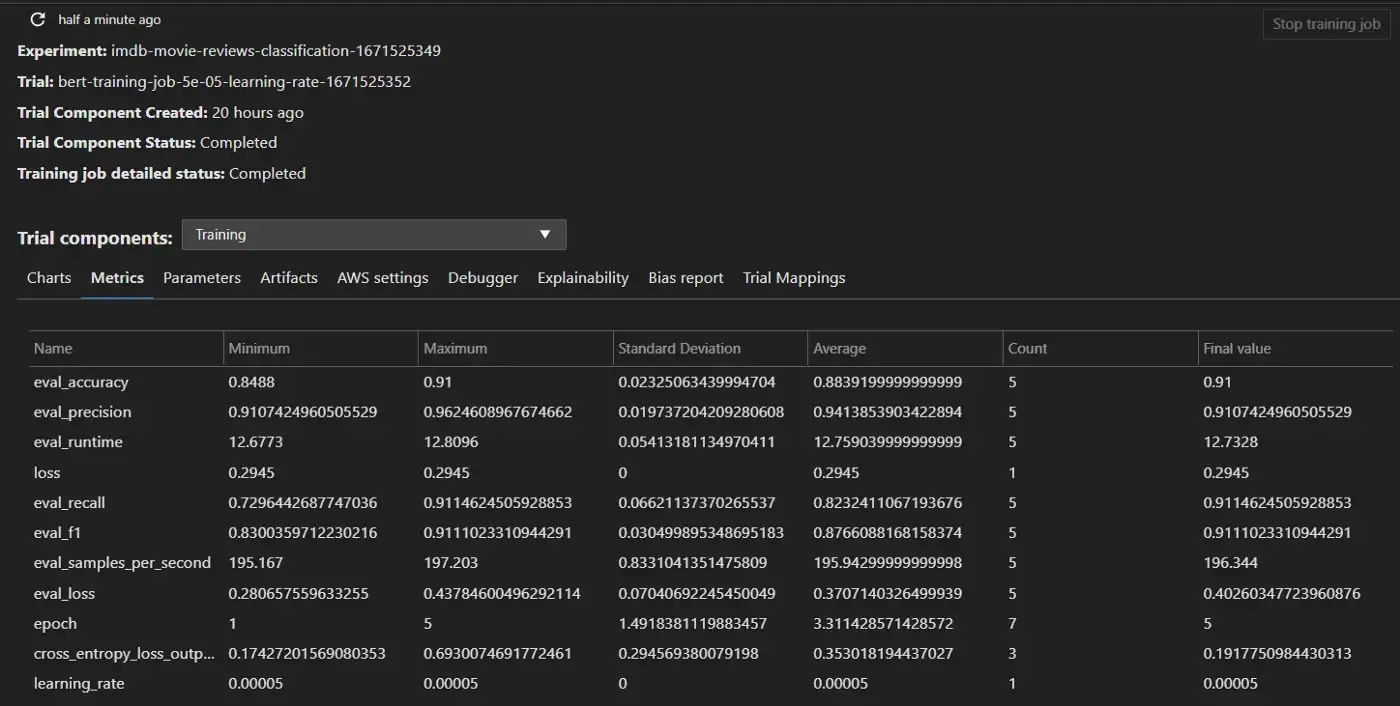

Let’s create a chart using eval_loss and eval_f1 metrics to monitor the model performance.

eval_loss_last vs timestamp graph:

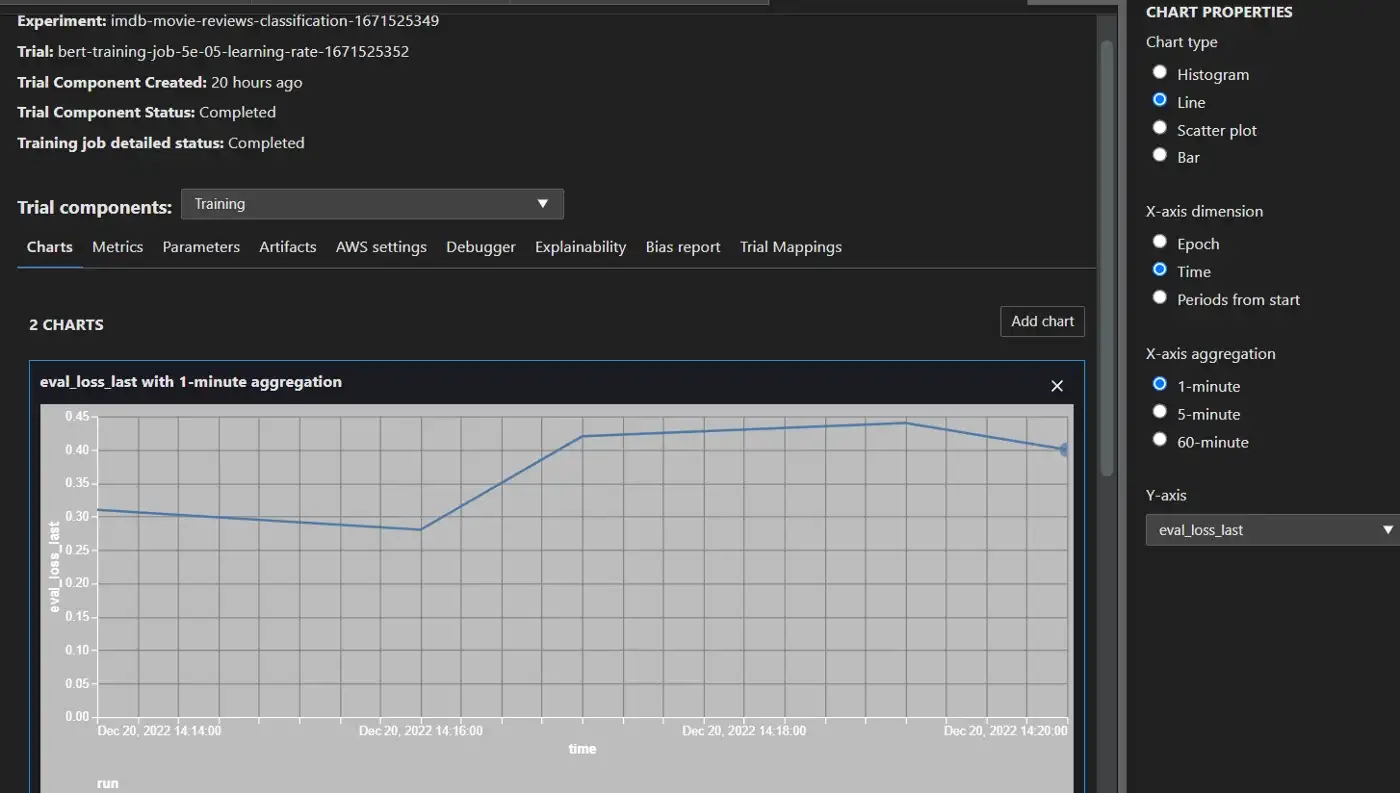

eval_f1_last vs timestamp graph:

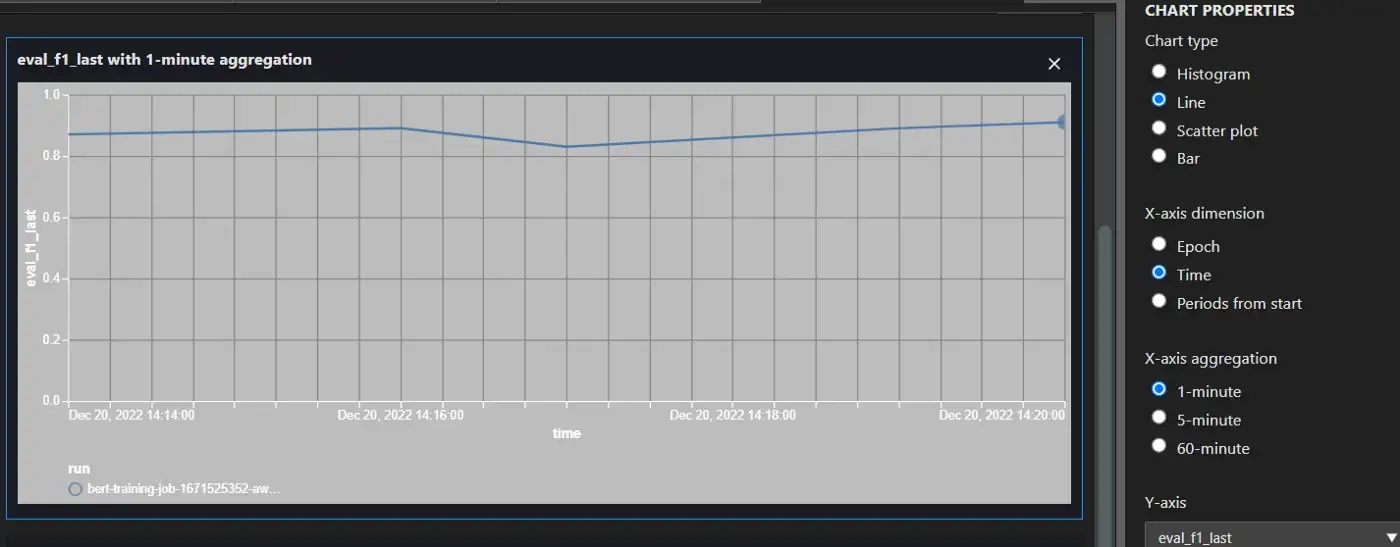

We can verify the input and output artifacts location used in specific training jobs. Also monitor the AWS settings (training instance details), training job parameters etc.

"bert-training-job-3e-05-learning-rate-1671348177" - Input and Output artifacts

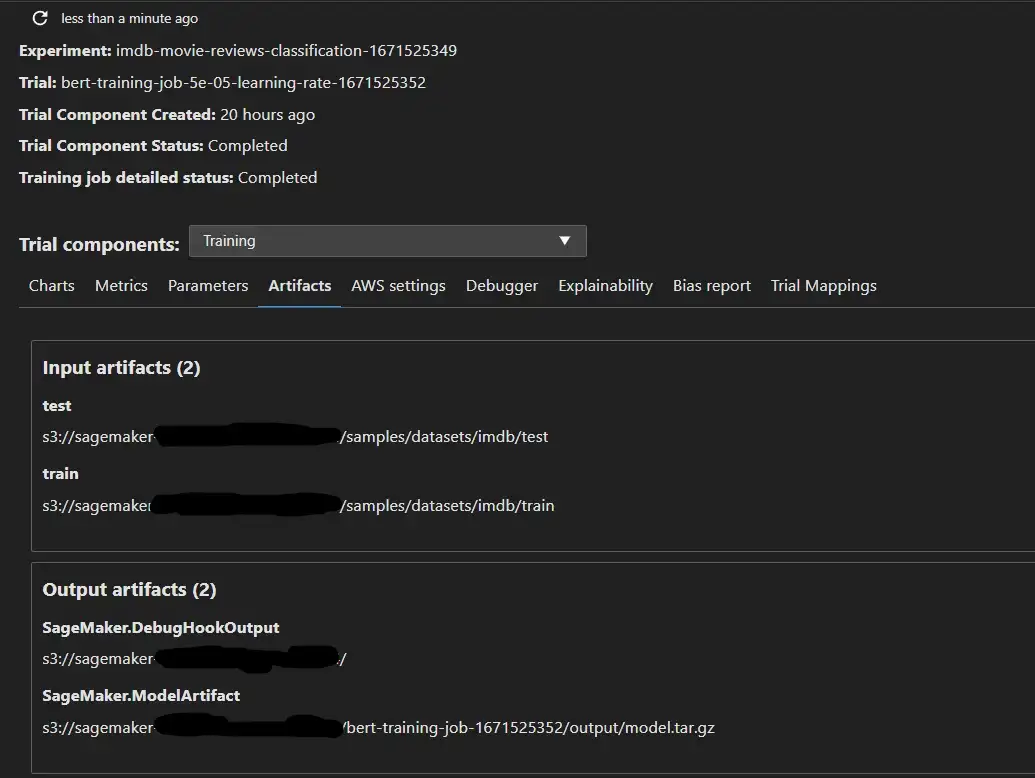

<a id = '8.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 8. Accessing Training Metrics using SageMaker TrainingJobAnalytics API </h2>

We can fetch the training history from CloudWatch Metrics for a specific training job using SageMaker `TrainingJobAnalytics` API call.

As shown in previous section, we can monitor the status of each training job in Experiments UI from Studio as well.

In [ ]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=pytorch_estimator.latest_training_job.name).dataframe()
df.head(10)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['figure.figsize'] = [15,5]

In [ ]:
evals = df[df.metric_name.isin(['eval_accuracy','eval_precision'])]
losses = df[df.metric_name.isin(['eval_loss'])]

sns.lineplot(
    x='timestamp', 
    y='value', 
    data=evals, 
    hue='metric_name', 
    palette=['blue', 'purple'],  legend="full")

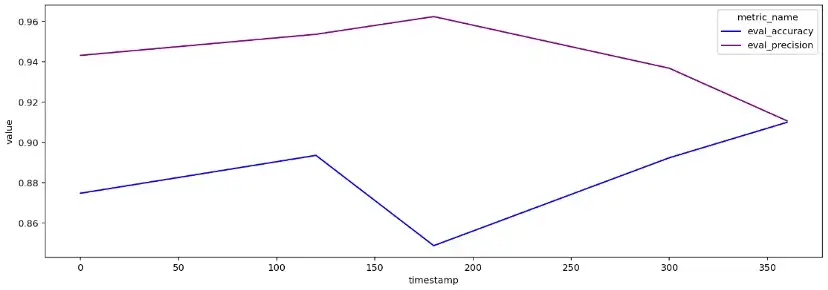

In [ ]:
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=losses, 
    hue='metric_name', 
    palette=['orange', 'red'])

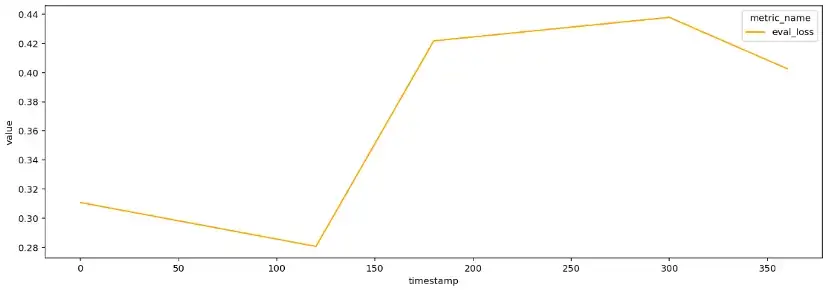

<a id = '9.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 9. Accessing Training Metrics using Weights and Biases</h2>

- We need to add a few lines of code to the training script to send the training metrics from SageMaker to W&B. For example:

    import wandb

    wandb.login(key="WANDB_API_KEY") # Pass your W&B API key here

    wandb.init(project='huggingface')

- Pass one additional parameter to transformers TrainingArguments to report training metrics to W&B.

    training_args = TrainingArguments(
        .......
        .......
        report_to="wandb"
    )

After we launch the three different training jobs with different learning rates then we can check out a variety of metrics such as losses, accuracy, f1-score, system metrics, and gradient histograms by logging to our W&B account.

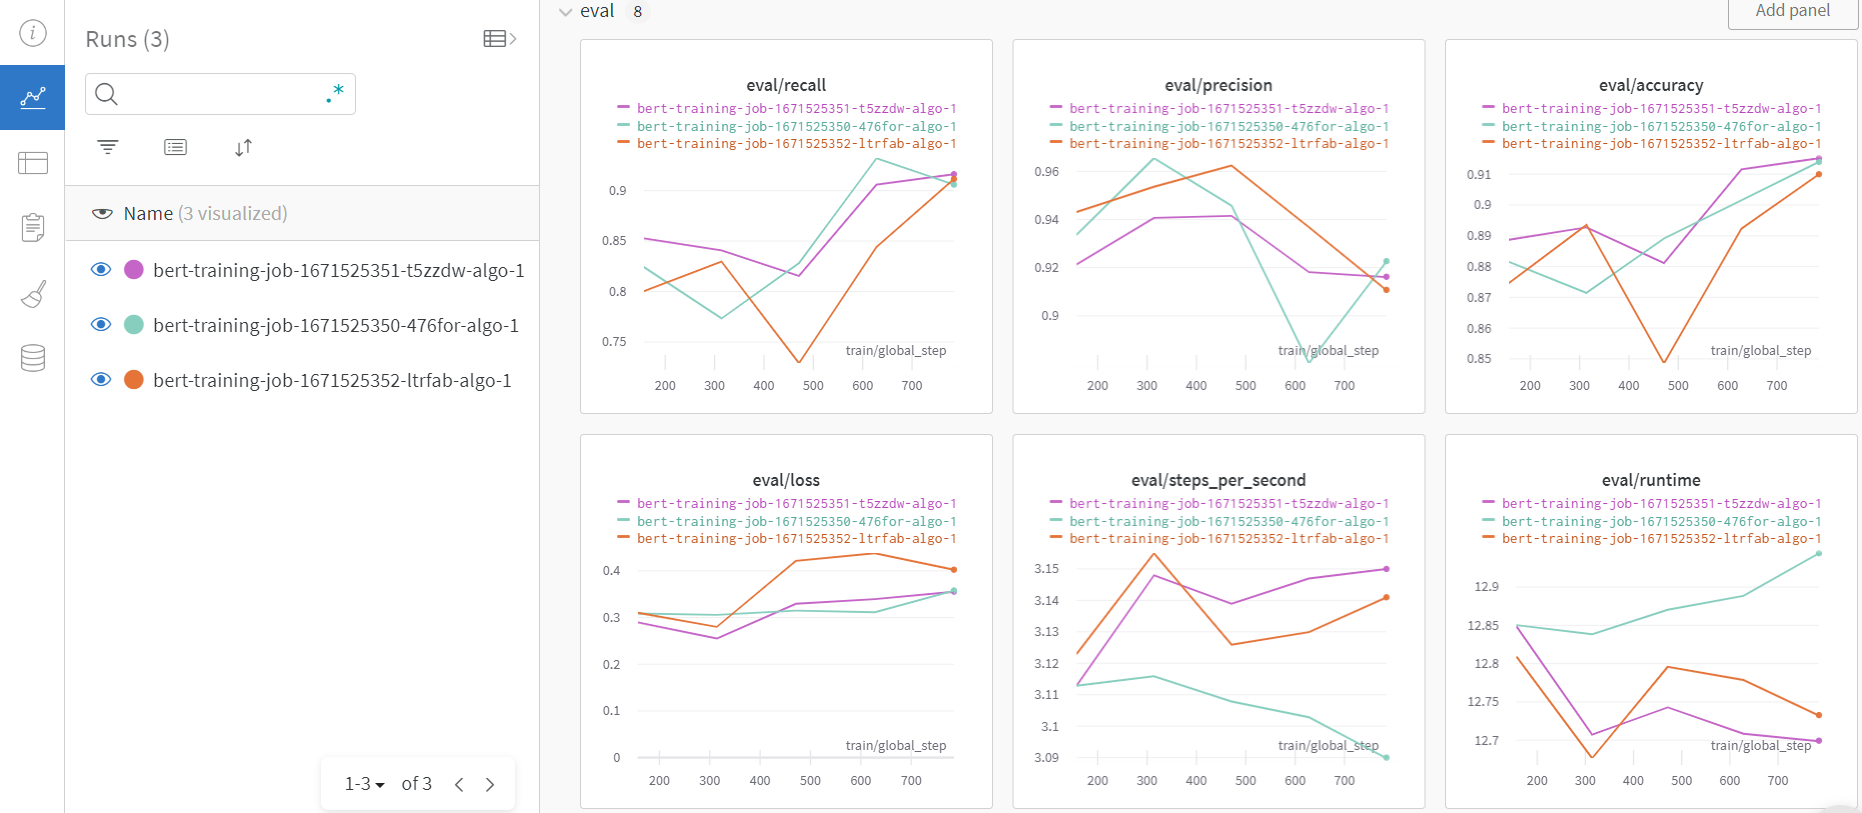

<a id = '10.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 10. Compare the model training runs for an experiment </h2>

Now we will use the analytics capabilities of Python SDK to query and compare the training runs for identifying the best model produced by our experiment. We can retrieve trial components by using a search expression.

### Some Simple Analysis

In [ ]:
search_expression = {
    "Filters": [
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [ ]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(boto3_sess, sm),
    experiment_name=imdb_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.eval_f1.max",
    sort_order="Descending",
    metric_names=["eval_f1"],
    parameter_names=["learning_rate", "epochs"],
)

In [ ]:
trial_component_analytics.dataframe()

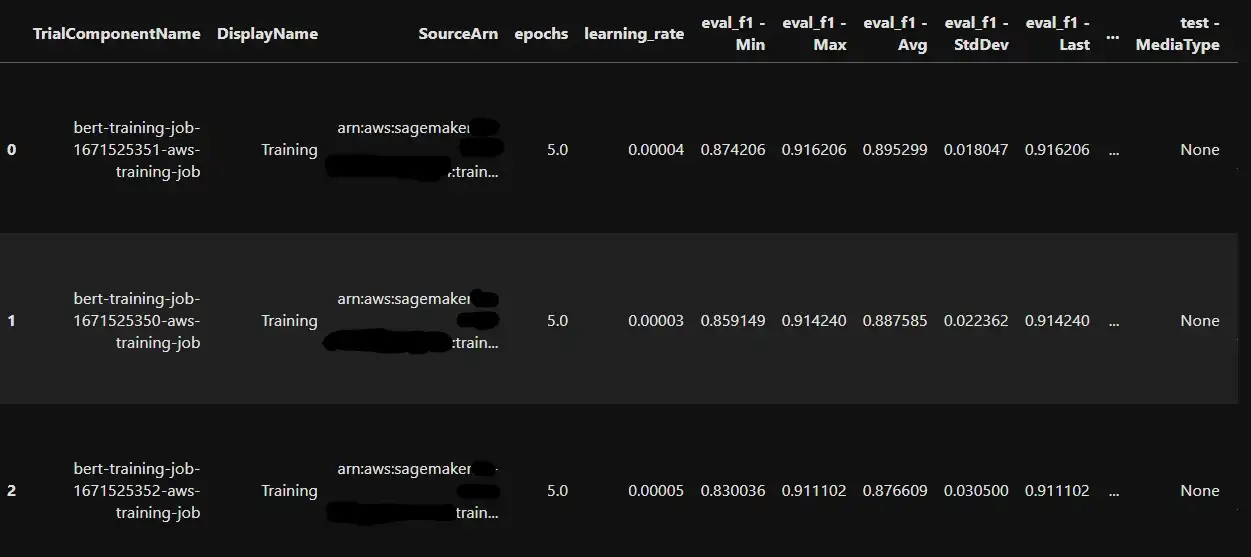

By looking at the eval_f1 score, a model trained with learning rate = 4e-05 is performing better than other two models.

To isolate and measure the impact of change in learning rates on model accuracy, we vary the learning rate value and fix the value for other hyperparameters.

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for `bert-training-job-4e-05-learning-rate-1671525351` trial

In [ ]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(boto3_sess, sm),
    search_expression={
        "Filters": [
            {
                "Name": "Parents.TrialName",
                "Operator": "Equals",
                "Value": learning_rate_trial_name_map[4e-05],
            }
        ]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [ ]:
lineage_table.dataframe()

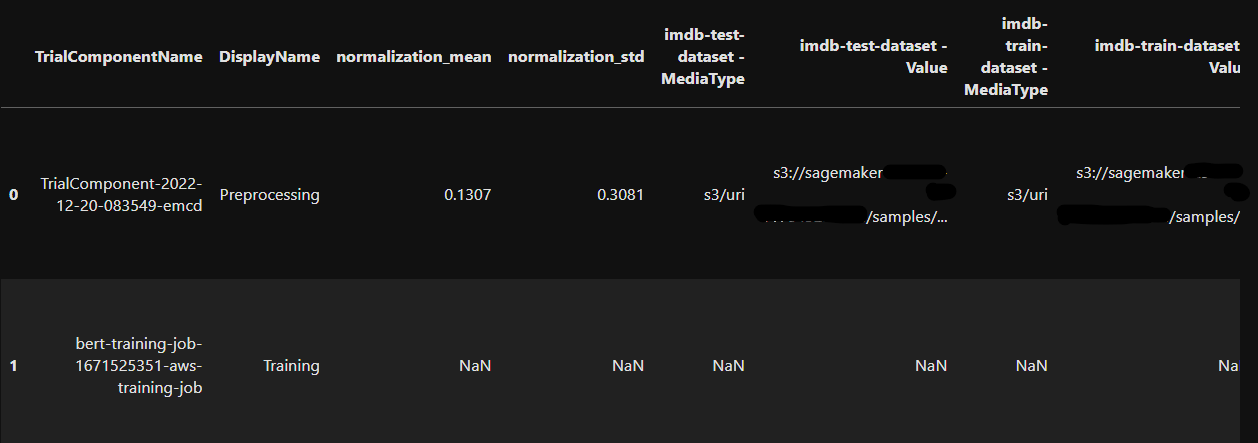

<a id = '11.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 11. Deploy endpoint for the best training-job or trial component </h2>

Now we'll take the best (as sorted) and create an endpoint for it.

In [ ]:
from sagemaker.pytorch import PyTorch, PyTorchModel

# Pulling best based on sort in the analytics/dataframe so first is best....
best_trial_component_name = trial_component_analytics.dataframe().iloc[0]["TrialComponentName"]
best_trial_component = TrialComponent.load(best_trial_component_name)

model_data = best_trial_component.output_artifacts["SageMaker.ModelArtifact"].value
env = {
    "learning_rate": str(best_trial_component.parameters["learning_rate"]),
    "epochs": str(best_trial_component.parameters["epochs"]),
}

model = PyTorchModel(entry_point='train_deploy.py', 
                     source_dir='./code',
                     model_data=model_data, 
                     role=role, 
                     framework_version='1.9',
                     py_version='py38',
                     name=best_trial_component.trial_component_name,)
             
predictor = model.deploy(instance_type="ml.g4dn.xlarge", initial_instance_count=1)

<a id = '12.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 12. Model inference </h2> 

In [ ]:
predictor.serializer = sagemaker.serializers.JSONSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [ ]:
sentiment_input= {"text":"I love using the new Inference DLC."}

predictor.predict(sentiment_input)

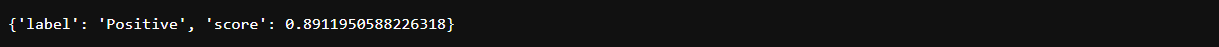

<a id = '13.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 13. Cleanup </h2> 

Once we're done don't forget to clean up the endpoint to prevent unnecessary billing.

> Trial components can exist independent of trials and experiments. We might want keep them if we plan on further exploration. If so, comment out `imdb_experiment.delete_all(action="--force")`

In [ ]:
predictor.delete_model()
predictor.delete_endpoint(delete_endpoint_config=True)

# Delete experiment artifacts
imdb_experiment.delete_all(action="--force")

<a id = '14.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 14. Conclusion </h2>

- Hope you enjoyed this post! This post will help you leverage the power of Amazon SageMaker experiments to organize, track, compare and evaluate our machine learning iterations then find the best performing training job and deploy an endpoint.

- SageMaker experiments logs every important metric during our model training runs, we’ll be able to analyze our performance and iterate towards better models more quickly.

- We also used the Weights and Biases to log every custom metric during our model training jobs, visualize findings, and unlock collaboration by letting anyone on our team see our experiments and build on top of them.

- Based on personal interest we can leverage the SageMaker experiments UI or TrainingJobAnalytics API or Weights and Biases to visualize the training history.

- Finally we have to clean up SageMaker experiments and endpoint to avoid charges.

I would love to hear your suggestions on further improvements and also welcome your code contribution to the [github repo](https://github.com/Vinayaks117/AWS-SageMaker-Examples.git)

<a id = '12.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> References </h2>

- [Amazon SageMaker Experiments – Organize, Track And Compare Your Machine Learning Trainings](https://aws.amazon.com/blogs/aws/amazon-sagemaker-experiments-organize-track-and-compare-your-machine-learning-trainings/)

- [Manage Machine Learning with Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html)

- [Integrating Weights & Biases to AWS SageMaker](https://wandb.ai/wandb/sm-pytorch-mnist-new/reports/Using-AWS-Sagemaker-and-Weights-Biases-Together-on-Digit-Recognition-with-MNIST---Vmlldzo4MTk3Nzg)

- [Monitor and Analyze Training Jobs Using Amazon CloudWatch Metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html)